# Tugas Mata Kuliah Deep Learning

- Model: Fully Connected Neural Network (FCNN)
- Oversampling: SMOTEENN
- Optimizer: Adam
- Validasi Silang: Holdout validation (train-test split)
- Metode Tambahan: L2 regularizer, EarlyStopping
- Fungsi Loss: Binary Crossentropy

Data Understanding dan Preliminary Analysis

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from imblearn.combine import SMOTETomek
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [10]:
df = pd.read_csv('../dl-b-project/5/capture20110815-2.binetflow')

In [11]:
print("Dataset Overview:")
print(df.head())

Dataset Overview:
                    StartTime        Dur Proto         SrcAddr  Sport    Dir  \
0  2011/08/15 16:43:28.078942   0.000000   tcp   114.33.245.44   6881     ?>   
1  2011/08/15 16:43:32.283576  13.431962   tcp   212.93.105.52  49237     ->   
2  2011/08/15 16:43:32.456441  13.350228   tcp   212.93.105.52  14906     ->   
3  2011/08/15 16:43:32.850648  13.010090   tcp   212.93.105.52  60349     ->   
4  2011/08/15 16:45:09.305002  20.990047   tcp  115.127.24.116   3198     ->   

         DstAddr  Dport   State  sTos  dTos  TotPkts  TotBytes  SrcBytes  \
0  147.32.84.118   1567     RA_   0.0   0.0        1        60        60   
1  147.32.84.229     80  SRA_SA   0.0   0.0        6       388       208   
2  147.32.84.229  13363  SRA_SA   0.0   0.0        6       388       208   
3  147.32.84.229    443  SRA_SA   0.0   0.0        6       388       208   
4  147.32.84.229    443   SR_SA   0.0   0.0        5       308       122   

                             Label  
0      

In [12]:
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129832 entries, 0 to 129831
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   StartTime  129832 non-null  object 
 1   Dur        129832 non-null  float64
 2   Proto      129832 non-null  object 
 3   SrcAddr    129832 non-null  object 
 4   Sport      129035 non-null  object 
 5   Dir        129832 non-null  object 
 6   DstAddr    129832 non-null  object 
 7   Dport      129455 non-null  object 
 8   State      129832 non-null  object 
 9   sTos       128974 non-null  float64
 10  dTos       122936 non-null  float64
 11  TotPkts    129832 non-null  int64  
 12  TotBytes   129832 non-null  int64  
 13  SrcBytes   129832 non-null  int64  
 14  Label      129832 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 14.9+ MB
None


In [13]:
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
                 Dur           sTos           dTos        TotPkts  \
count  129832.000000  128974.000000  122936.000000  129832.000000   
mean       77.439645       0.049382       0.000724      34.514927   
std       282.290550       3.024701       0.043716    2494.261136   
min         0.000000       0.000000       0.000000       1.000000   
25%         0.000304       0.000000       0.000000       2.000000   
50%         0.000739       0.000000       0.000000       2.000000   
75%         0.643476       0.000000       0.000000       6.000000   
max      1805.828491     192.000000       3.000000  694553.000000   

           TotBytes      SrcBytes  
count  1.298320e+05  1.298320e+05  
mean   2.883615e+04  5.081775e+03  
std    2.962769e+06  5.179676e+05  
min    6.000000e+01  0.000000e+00  
25%    2.140000e+02  7.600000e+01  
50%    2.660000e+02  8.100000e+01  
75%    7.410000e+02  4.600000e+02  
max    8.537041e+08  1.365468e+08  


In [14]:
print("\nUnique Labels in 'Label':")
print(df['Label'].value_counts())


Unique Labels in 'Label':
Label
flow=To-Background-UDP-CVUT-DNS-Server                      50817
flow=Background-UDP-Established                             37203
flow=Background-TCP-Established                             15156
flow=Background-Established-cmpgw-CVUT                       9331
flow=Background                                              3426
                                                            ...  
flow=From-Botnet-V46-TCP-HTTP-Google-Net-Established-6          1
flow=From-Botnet-V46-TCP-Established-Custom-Encryption-8        1
flow=From-Botnet-V46-TCP-Established-HTTP-Ad-4                  1
flow=From-Botnet-V46-TCP-CC7-Custom-Encryption                  1
flow=From-Botnet-V46-TCP-Established                            1
Name: count, Length: 77, dtype: int64


In [15]:
df.isnull().sum()

StartTime       0
Dur             0
Proto           0
SrcAddr         0
Sport         797
Dir             0
DstAddr         0
Dport         377
State           0
sTos          858
dTos         6896
TotPkts         0
TotBytes        0
SrcBytes        0
Label           0
dtype: int64

Data Cleaning

In [16]:
# Mengisi nilai kosong di kolom numerik dengan median
numeric_cols = ['Dur', 'TotPkts', 'TotBytes', 'SrcBytes', 'sTos', 'dTos']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Mengisi nilai kosong di kolom kategorikal dengan mode
categorical_cols = ['SrcAddr', 'DstAddr', 'Sport', 'Dport']
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Menghapus kolom yang memiliki banyak nilai kosong atau tidak relevan
df.drop(['StartTime'], axis=1, inplace=True)

# Membuat kolom untuk menandai apakah data termasuk botnet (1) atau normal (0)
df['is_botnet'] = df['Label'].apply(lambda x: 1 if 'Botnet' in x else 0)

# Verifikasi distribusi kelas
print("\nDistribusi Data (Normal vs Botnet):")
print(df['is_botnet'].value_counts(normalize=True) * 100)



print(f"Dataset shape after cleaning: {df.shape}")
print(f"Missing values: \n{df.isnull().sum()}")


Distribusi Data (Normal vs Botnet):
is_botnet
0    99.306026
1     0.693974
Name: proportion, dtype: float64
Dataset shape after cleaning: (129832, 15)
Missing values: 
Dur          0
Proto        0
SrcAddr      0
Sport        0
Dir          0
DstAddr      0
Dport        0
State        0
sTos         0
dTos         0
TotPkts      0
TotBytes     0
SrcBytes     0
Label        0
is_botnet    0
dtype: int64


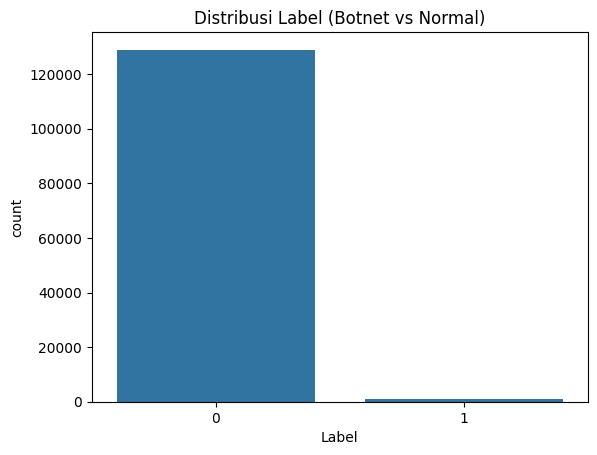

In [36]:
# Distribusi kelas
sns.countplot(data=df, x='Label')
plt.title('Distribusi Label (Botnet vs Normal)')
plt.show()

Data Preprocessing

In [37]:
# Konversi fitur kategorikal menjadi numerik
df = pd.get_dummies(df, columns=['Proto', 'Dir', 'State'], drop_first=True)

# Split data menjadi X dan y
X = df.drop(categorical_cols + ['Label'], axis=1)
y = df['Label']

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Shape of X_train: {X_train.shape}, Shape of X_test: {X_test.shape}")

Shape of X_train: (103865, 175), Shape of X_test: (25967, 175)


In [39]:
from imblearn.combine import SMOTEENN

# SMOTE + ENN untuk oversampling
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Verifikasi distribusi setelah SMOTE+ENN
print(f"Distribusi Label Setelah SMOTE+ENN:\n{pd.Series(y_train_resampled).value_counts()}")


Distribusi Label Setelah SMOTE+ENN:
Label
0    100446
1    100090
Name: count, dtype: int64


In [40]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve

# Menambah jumlah epoch dan menggunakan Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model baru dengan optimasi learning rate dan regularisasi
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [41]:
model_optimized = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_resampled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile model dengan learning rate lebih rendah
model_optimized.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Train model
history_optimized = model_optimized.fit(
    X_train_resampled, 
    y_train_resampled, 
    validation_split=0.2, 
    epochs=20, 
    batch_size=64, 
    callbacks=[early_stopping], 
    verbose=1
)

c:\Users\AHMAD ZAKI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - AUC: 0.9353 - accuracy: 0.8876 - loss: 0.3974 - val_AUC: 0.0000e+00 - val_accuracy: 0.9416 - val_loss: 0.3973
Epoch 2/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.9438 - accuracy: 0.9031 - loss: 0.2811 - val_AUC: 0.0000e+00 - val_accuracy: 0.9423 - val_loss: 0.3720
Epoch 3/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.9457 - accuracy: 0.9038 - loss: 0.2686 - val_AUC: 0.0000e+00 - val_accuracy: 0.9412 - val_loss: 0.3655
Epoch 4/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.9493 - accuracy: 0.9051 - loss: 0.2615 - val_AUC: 0.0000e+00 - val_accuracy: 0.9415 - val_loss: 0.3594
Epoch 5/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.9488 - accuracy: 0.9045 - loss: 0.2624 - val_AUC: 0.0000e+00 - val_accuracy: 0.9434 - val_loss: 0.3591
Epoch 6/20
2507/2507 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - AUC: 0.9489 - accuracy: 0.9049 - loss: 0.2618 - val_AUC: 0.0000e+00 - val_accuracy: 0.9408 - val_loss: 0.3706
Ep

Test Loss: 0.2787
Test Accuracy: 0.8696
Test AUC: 0.9397


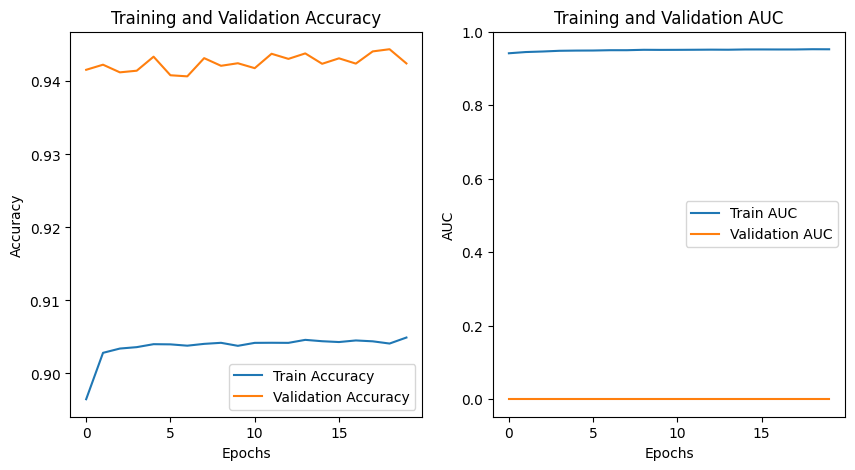

812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


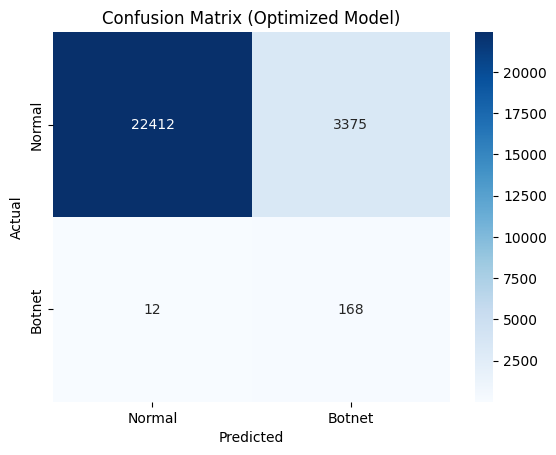


Classification Report (Optimized Model):
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     25787
           1       0.05      0.93      0.09       180

    accuracy                           0.87     25967
   macro avg       0.52      0.90      0.51     25967
weighted avg       0.99      0.87      0.92     25967

812/812 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


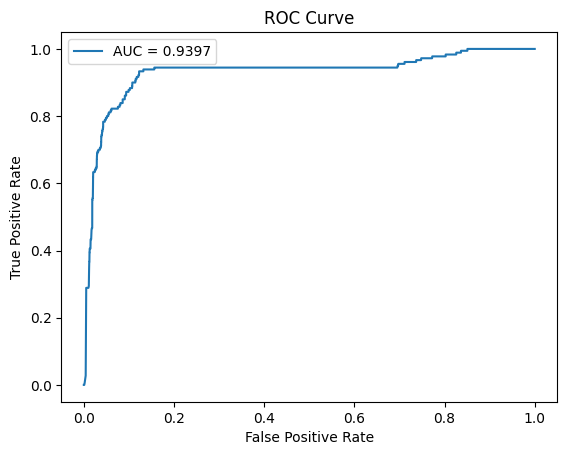

In [48]:
# Evaluasi pada data test
loss, accuracy, auc = model_optimized.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")

# Plot training history (accuracy dan AUC)
plt.figure(figsize=(10, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_optimized.history['accuracy'], label='Train Accuracy')
plt.plot(history_optimized.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

# Plot Training and Validation AUC
plt.subplot(1, 2, 2)
plt.plot(history_optimized.history['AUC'], label='Train AUC')
plt.plot(history_optimized.history['val_AUC'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.title("Training and Validation AUC")
plt.show()

# Confusion Matrix
y_pred_optimized = (model_optimized.predict(X_test) > 0.5).astype("int32")
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm_optimized, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Botnet'], yticklabels=['Normal', 'Botnet'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Optimized Model)")
plt.show()

# Classification Report
print("\nClassification Report (Optimized Model):")
print(classification_report(y_test, y_pred_optimized))

# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, model_optimized.predict(X_test))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()